In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
path_to_data = r'../data/python-and-analyze-data-final-project/'

# example of Kaggle submission
path_to_submission_example = os.path.join(path_to_data, 'gender_test_kaggle_sample_submission.csv')

# all transactions (train and test)
path_to_transactions = os.path.join(path_to_data, 'transactions.csv')

# train labels
path_to_train = os.path.join(path_to_data, 'gender_train.csv')

# description of every code in data
path_to_codes = os.path.join(path_to_data, 'tr_mcc_codes.csv')

# description of every type in data
path_to_types = os.path.join(path_to_data, 'tr_types.csv')

## Kaggle submission example

In [3]:
submission = pd.read_csv(path_to_submission_example)
submission.head()

,customer_id,probability
0,75562265,0.152664
1,84816985,0.302357
2,54129921,0.062036
3,23160845,0.459860
4,45646491,0.835253


In [4]:
submission.probability.min(), submission.probability.max()

(0.0003133421583925, 0.999559543268052)

#### Yes, field `probability` really represents a probablity of gender (we are expexted to submit raw probabilities)

In [5]:
submission.shape

(3600, 2)

## Train data (all transactions)

In [6]:
transactions = pd.read_csv(path_to_transactions)
transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


In [7]:
transactions.shape

(6849346, 6)

## Train labels

In [8]:
train_labels = pd.read_csv(path_to_train)
train_labels.head()

,customer_id,gender
0,10928546,1
1,69348468,1
2,61009479,0
3,74045822,0
4,27979606,1


### Train data labels distribution

In [9]:
train_labels.gender.value_counts() / train_labels.shape[0]

0    0.557976
1    0.442024
Name: gender, dtype: float64

## Description of every code

In [10]:
codes = pd.read_csv(path_to_codes, sep=';')
codes.head()

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело


In [11]:
codes.shape

(184, 2)

## Description of every type

In [12]:
types = pd.read_csv(path_to_types, sep=';')
types.head()

,tr_type,tr_description
0,3200,Плата за предоставление услуг посредством моби...
1,3210,Плата за предоставление отчета по счету карты ...
2,3800,Плата за обслуживание банковской карты (за пер...
3,4000,Плата за получение наличных в Сбербанке
4,4001,Плата за получение наличных в Сбербанке (в дру...


In [13]:
types.shape

(155, 2)

## Check ids connection

In [14]:
X_train_id = transactions['customer_id'].unique()
y_train_id = train_labels['customer_id'].unique()
y_test_id = submission['customer_id'].unique()

X_train_id.shape, y_train_id.shape, y_test_id.shape

((15000,), (8400,), (3600,))

In [15]:
for train_id in y_train_id:
    assert train_id in X_train_id
    assert train_id not in y_test_id
# For every train_id we have corresponding transactions history in our data
# There is no train_id inside test_ids

for test_id in y_test_id:
    assert test_id in X_train_id
    assert test_id not in y_train_id
# For every test_id we have corresponding transactions history in our data
# There is no test_id inside train_ids

## Data preparation

customer_id -- key for reduce/groupby operation. Create remapping and use as a groupby feature

tr_datetime -- key for sort after reduce operation (maybe create some time-aware features) (TODO) 

mcc_code -- categorical feature. Create remapping + use as a learnable embedding in the projector (TODO)

tr_type -- categorical feature. Create remapping + user as a learnable embedding in the projector (TODO)

amount -- scalar feature. Create logarithmic version of it. Maybe create feature enginering (TODO)

term_id -- ?????. Probably a good idea to drop this feature (TODO)

Aggregation -- we can try sum or concat as a different approaches. Probably sum by default.

### Customer ID

In [16]:
transactions['customer_id_factorized'] = transactions['customer_id'].factorize()[0]
transactions.head(30)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,customer_id_factorized
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,0
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,0
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,0
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,0
5,39026145,2 15:53:49,5541,1010,-14643.37,NaN,0
6,39026145,3 15:29:08,5499,1010,-1010.66,NaN,0
7,39026145,4 12:11:57,5200,1010,-2829.85,NaN,0
8,39026145,5 15:19:19,5499,1010,-628.86,NaN,0
9,39026145,6 07:08:31,4814,1030,-5614.79,NaN,0


In [17]:
transactions.tail(20)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,customer_id_factorized
6849326,61870738,445 13:44:21,5331,1010,-1769.78,407527,14999
6849327,61870738,445 13:58:48,5651,1010,-4491.83,10283987,14999
6849328,61870738,445 20:22:03,5541,1110,-6737.75,RU570124,14999
6849329,61870738,446 19:04:27,5912,1010,-13201.72,972819,14999
6849330,61870738,446 19:19:25,5411,1010,-8803.99,042291,14999
6849331,61870738,447 07:22:13,4814,1030,-2245.92,888993,14999
6849332,61870738,448 20:25:26,5541,1110,-4491.83,RU570124,14999
6849333,61870738,450 16:37:55,5411,1110,-18034.70,22402258,14999
6849334,61870738,451 11:12:53,5499,1010,-7968.51,10217113,14999
6849335,61870738,452 11:52:41,5411,1110,-2223.46,22350752,14999


### Transaction datetime

Since format is undefined, we suppose that format of a time stamp is the following: [DAY] [HOUR]:[MINUTE]:[SECOND]

In [18]:
from datetime import datetime

In [19]:
transactions['timestamp'] = transactions.apply(
    lambda x: (
        (60 * 60 * 24 * int(x['tr_datetime'].split()[0])) 
        + (60 * 60 * int(x['tr_datetime'].split()[1][:2]))
        + 60 * int(x['tr_datetime'].split()[1][3:5])
        + int(x['tr_datetime'].split()[1][6:8])
    ), axis=1
)

In [20]:
transactions.head(30)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,customer_id_factorized,timestamp
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0,37406
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,0,123569
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,0,123656
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,0,124794
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,0,228822
5,39026145,2 15:53:49,5541,1010,-14643.37,NaN,0,230029
6,39026145,3 15:29:08,5499,1010,-1010.66,NaN,0,314948
7,39026145,4 12:11:57,5200,1010,-2829.85,NaN,0,389517
8,39026145,5 15:19:19,5499,1010,-628.86,NaN,0,487159
9,39026145,6 07:08:31,4814,1030,-5614.79,NaN,0,544111


### Mcc code and Transaction type.

These features are categorical, so we just want to re-map them

In [21]:
transactions['mcc_code_factorized'] = transactions['mcc_code'].factorize()[0]
transactions['tr_type_factorized'] = transactions['tr_type'].factorize()[0]
transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,customer_id_factorized,timestamp,mcc_code_factorized,tr_type_factorized
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0,37406,0,0
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,0,123569,1,1
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,0,123656,2,2
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,0,124794,3,3
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,0,228822,3,3


## `Amount` field analyzis

In [22]:
transactions.amount.min(), transactions.amount.max()

(-145984525.17, 145984525.17)

<AxesSubplot:>

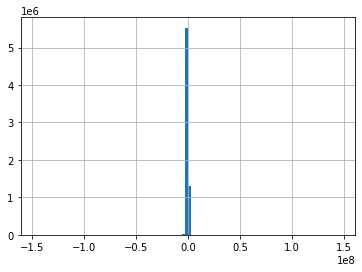

In [23]:
transactions.amount.hist(bins=100)

In [24]:
transactions['amount_log'] = transactions.apply(
    lambda x: np.sign(x['amount']) * np.log(1 + np.abs(x['amount'])),
    axis=1
)

In [25]:
transactions.amount_log.min(), transactions.amount_log.max()

(-18.799011188918804, 18.799011188918804)

<AxesSubplot:>

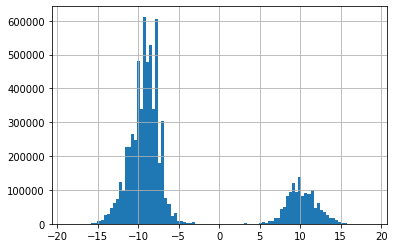

In [26]:
transactions.amount_log.hist(bins=100)  # Probably it will be better to work with logarithm of amount

In [28]:
transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,customer_id_factorized,timestamp,mcc_code_factorized,tr_type_factorized,amount_log
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0,37406,0,0,-7.717316
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,0,123569,1,1,10.935762
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,0,123656,2,2,-10.935762
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,0,124794,3,3,-7.239552
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,0,228822,3,3,-6.826361


In [29]:
print(f'Number of customers: {transactions["customer_id"].unique().shape[0]}')
print(f'Mean transaction length: {transactions.shape[0] / transactions["customer_id"].unique().shape[0]}')

Number of customers: 15000
Mean transaction length: 456.62306666666666


## Save datasets

In [30]:
transactions.to_csv(os.path.join(path_to_data, 'all_transactions.csv'))